In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import optimizers
from keras import losses
from keras.losses import mse, binary_crossentropy
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Lambda, Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard


import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import sys
import os

In [2]:
class visualization:
    labels = ["Normal", "Anomaly"]
    def draw_confusion_matrix(self, y, y_pred):
        matrix = confusion_matrix(y_true=y, y_pred=y_pred)
        
        plt.figure(figsize=(7,5))
        colors =['orange', 'green']
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels,
                   cmap=colors, annot=True, fmt='d')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        
        
    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error':error, 'true':y}).groupby('true')
        
        figure, axes = plt.subplots(figsize=(12, 8))
        
        for name, group in groupsDF:
            axes.plot(group.index, group.error, linestyle='',
                      marker='x' if name == 1 else 'o',
                      color='r' if name == 1 else 'g',
                      label='Anomaly' if name == 1 else 'Normal'
                      )
        axes.hlines(threshold, xmin=axes.get_xlim()[0], xmax=axes.get_xlim()[1],
                   colors='b', zorder=100, label='Threshold')
        axes.legend()

        plt.title("Anomalies")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
            
    def draw_error(self, error, threshold):
        figure, axes = plt.subplots(figsize=(12, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')
        plt.hlines(threshold, xmin=0, xmax=len(error)-1,
                   colors='b', zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
        

In [3]:
df = pd.read_csv('../data/creditcard.csv')

In [4]:
df['Amount'] = StandardScaler().fit_transform(df["Amount"].values.reshape(-1, 1))
df0 = df[df['Class'] == 0].sample(20000)
df1 = df[df['Class'] == 1].sample(400)
df = pd.concat([df0, df1])

In [5]:
x_train, x_test, y_train, y_test = \
    train_test_split(df.drop(labels=['Time', 'Class'], axis=1), 
                     df['Class'], test_size=0.2, random_state=101)

print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(16320, 29) train samples
(4080, 29) test samples


In [6]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

## Create model

In [7]:
original_dim = x_train.shape[1]
print(original_dim)

input_shape = (original_dim,)
intermediate_dim = 12
# batch_size = 32
latent_dim = 2
# epoch = 20

inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= original_dim

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


29
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 29)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 12)                   360       ['encoder_input[0][0]']       
                                                                                                  
 z_mean (Dense)              (None, 2)                    26        ['dense[0][0]']               
                                                                                                  
 z_log_var (Dense)           (None, 2)                    26        ['dense[0][0]']               
                                                                                         

In [8]:
vae.compile(optimizer='adam', 
            loss='mean_squared_error', 
            metrics=['accuracy'])
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 29)]                 0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  412       ['encoder_input[0][0]']       
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 29)                   413       ['encoder[0][2]']             
                                                                                            

In [9]:
log_dir = os.path.join('D:', os.sep, 'DS', 'DL', 'Concepts', 'logs', 'VAE-01')
print(log_dir)

D:\DS\DL\Concepts\logs\VAE-01


In [10]:
from shutil import rmtree
rmtree(log_dir, ignore_errors=True)

# if os.path.isdir(log_dir):
#     rmtree(log_dir)
#     print('Log directory deleted!: ', os.path.isdir(log_dir))
# else:
#     print('No such directory found!')

In [11]:
batch_size = 64
epochs = 50

history = vae.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         shuffle=True,
                         validation_data=(x_test, y_test),
                         callbacks= [TensorBoard(log_dir=log_dir)]
                         )

Epoch 1/50
255/255 [==============================] - 1s 2ms/step - loss: 996411.0625 - accuracy: 0.0096 - val_loss: 171.8480 - val_accuracy: 0.0110
Epoch 2/50
255/255 [==============================] - 0s 1ms/step - loss: 1292.3350 - accuracy: 0.0117 - val_loss: 84.4739 - val_accuracy: 0.0054
Epoch 3/50
255/255 [==============================] - 0s 1ms/step - loss: 203.2277 - accuracy: 0.0077 - val_loss: 57.7803 - val_accuracy: 0.0039
Epoch 4/50
255/255 [==============================] - 0s 1ms/step - loss: 128.0335 - accuracy: 0.0043 - val_loss: 48.7128 - val_accuracy: 0.0042
Epoch 5/50
255/255 [==============================] - 0s 1ms/step - loss: 96.3152 - accuracy: 0.0075 - val_loss: 45.4524 - val_accuracy: 0.0086
Epoch 6/50
255/255 [==============================] - 0s 1ms/step - loss: 79.7381 - accuracy: 0.0107 - val_loss: 44.1462 - val_accuracy: 0.0132
Epoch 7/50
255/255 [==============================] - 0s 1ms/step - loss: 69.8406 - accuracy: 0.0120 - val_loss: 43.6204 - val_

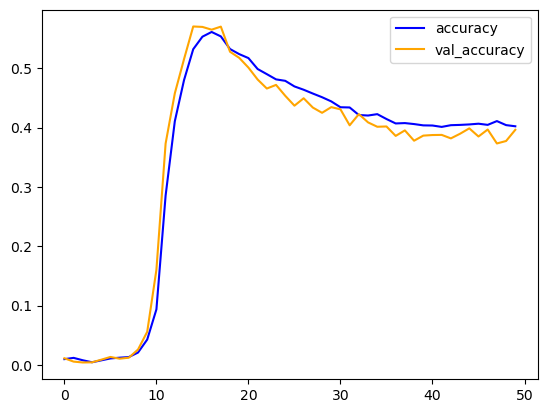

In [12]:
plt.plot(history.history['accuracy'], color='b', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
plt.legend()

In [13]:
score = vae.evaluate(x_train, y_train, verbose=1)
print('Test loss:', score[0])
print('Test Accuracy:', score[1])

510/510 [==============================] - 0s 879us/step - loss: 44.8453 - accuracy: 0.4078
Test loss: 44.84531021118164
Test Accuracy: 0.4077818691730499


In [14]:
# measure anomalies based on a threshold
threshold = 20.00

y_pred = vae.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)

y_label =[]
error = []

for index, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    
    error.append(y_dist)

128/128 [==============================] - 0s 477us/step


In [15]:
roc_auc_score(y_test, y_label)

0.6904165938312424

In [16]:
print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4013
           1       0.47      0.39      0.43        67

    accuracy                           0.98      4080
   macro avg       0.73      0.69      0.71      4080
weighted avg       0.98      0.98      0.98      4080



In [17]:
viz = visualization()

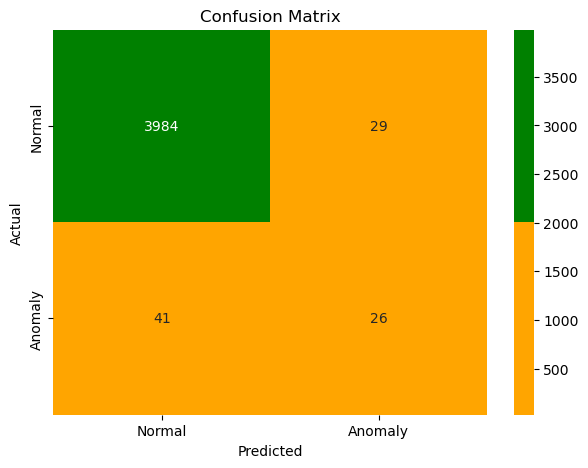

In [18]:
viz.draw_confusion_matrix(y_test, y_label)

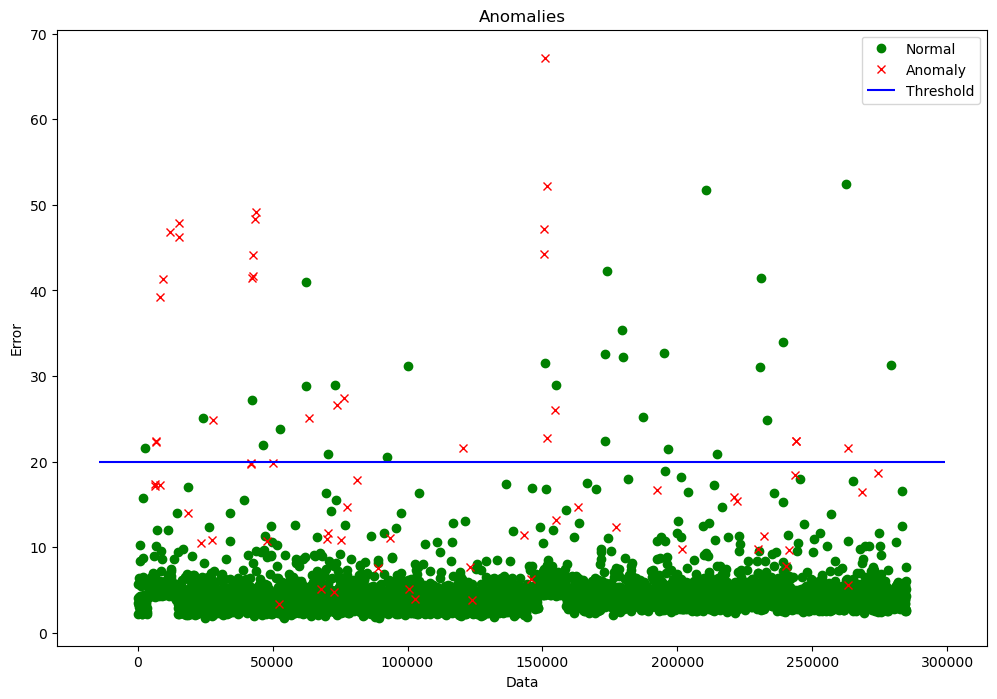

In [19]:
viz.draw_anomaly(y_test, error, threshold)

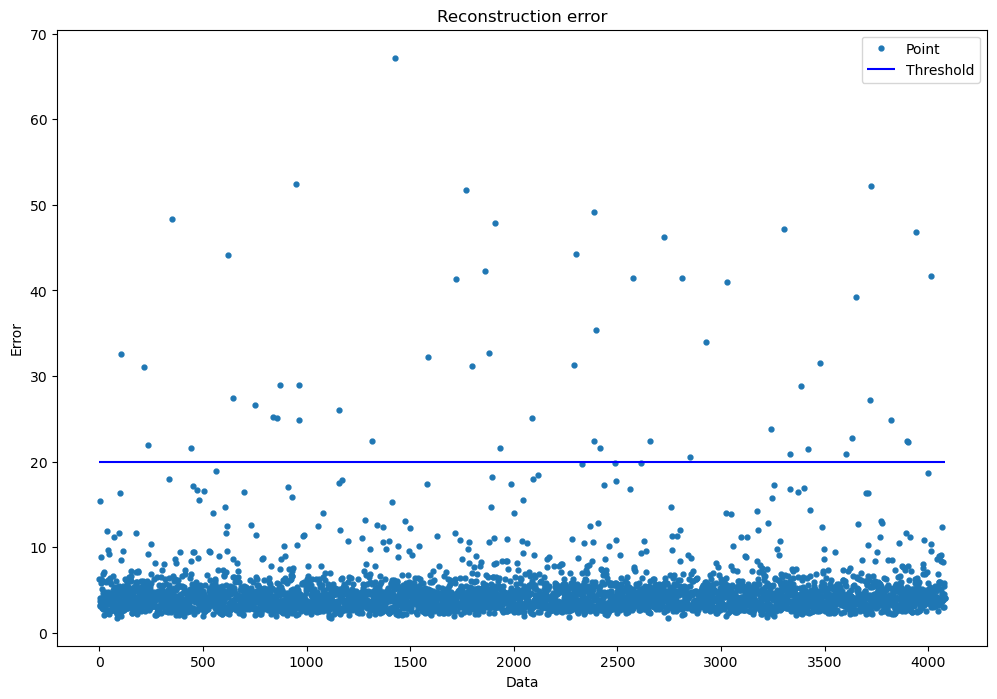

In [20]:
viz.draw_error(error, threshold)